There is mainly 2 group of neurons. 120 M neurons represents the motor neuron, their activity are transferred to muscle activity which activate 120 muscles in a musculoskeletal model in Mujoco. And then the muscle length observed in Mujoco.physics is transfered to 120 S neurons which represent the sensory neurons. The longer the muscles is, the higher the S neuron's activity is. At the beginning, the 120 M neurons have random relationships with each other. But with a rhythmic input to them, they were activated sequentially, and generate subtle movement in musculoskeletal model. Then the model feedback the muscle length to the sensory neuron. Because there are local circuits between S and M neurons, M neurons which have similar of opposite neurons would then have more and more related relationship. use Hebbian learning rule to update the neural network between S and M.

In [1]:
import mujoco as mj
from mujoco.glfw import glfw
import numpy as np
import os
from matplotlib import pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
xml_path = r"D:/CyberMice/assets/modified_xml_file_2.xml"
simend = 5 #simulation time 
print_camera_config = 0 # set to 1 to print camera config
                        # this is useful for initializing view of the model

In [3]:
# for callback function
button_left = False
button_middle = False
button_right = False
lastx = 0
lasty = 0 

In [4]:
model = mj.MjModel.from_xml_path(xml_path) # MuJoCo model
data = mj.MjData(model) # Mujoco data
cam = mj.MjvCamera() # Abstruct camera
opt = mj.MjvOption() # visualization options
num_actuators = model.nu

In [5]:
print(num_actuators)

148


Autoencoder Component:
1. Muscle Encoder:
    Input: dim=120 muscle activity
    Output: dim=32 muscle command
2. Muscle Decoder:
    Input: dim=32 muscle command 
    Output: dim=120 muscle activity
3. Sensor Encoder:
    Input: dim=120 sensor activity
    Output: dim=32 sensor representation
4. Sensor Decoder:
    Input: dim=32 muscle representation
    Output: dim=120 sensor activity

Network Architecture:
1. Muscle Autoencoder:
    Components: Muscle Encoder + Muscle Decoder
    Effects: Mapping between low-dim command and high-dim command
    Shortage: Not biological plausible
2. Sensor Autoencoder:
    Components: Sensor Encoder + Sensor Decoder
    Effects: Mapping between low-dim representation and high-dim activity
    Shortage: Not biological plausible
3. Kalman Estimator:
    Components: Muscle Encoder + Sensor Decoder
    Effects: Mapping muscle activity to sensory prediction; Use the error between S_est and S_true to update
    Shortage: Seems not necessary 

In [6]:
# Define Muscle Encoder
class MuscleEncoder(nn.Module):
    def __init__(self):
        super(MuscleEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(num_actuators, int(num_actuators/2)),
            nn.ReLU(),
            nn.Linear(int(num_actuators/2), int(num_actuators/4))
        )

    def forward(self, x):
        return self.encoder(x)

# Define Muscle Decoder
class MuscleDecoder(nn.Module):
    def __init__(self):
        super(MuscleDecoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.Linear(int(num_actuators/4), int(num_actuators/2)),
            nn.ReLU(),
            nn.Linear(int(num_actuators/2), int(num_actuators))
        )

    def forward(self, x):
        return self.decoder(x)

# Define Sensor Encoder
class SensorEncoder(nn.Module):
    def __init__(self):
        super(SensorEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(int(num_actuators), int(num_actuators/2)),
            nn.ReLU(),
            nn.Linear(int(num_actuators/2), int(num_actuators/4))
        )

    def forward(self, x):
        return self.encoder(x)

# Define Sensor Decoder
class SensorDecoder(nn.Module):
    def __init__(self):
        super(SensorDecoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.Linear(int(num_actuators/4), int(num_actuators/2)),
            nn.ReLU(),
            nn.Linear(int(num_actuators/2), int(num_actuators))
        )

    def forward(self, x):
        return self.decoder(x)

# Define Muscle Autoencoder
class MuscleAutoencoder(nn.Module):
    def __init__(self):
        super(MuscleAutoencoder, self).__init__()
        self.encoder = MuscleEncoder()
        self.decoder = MuscleDecoder()

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Define Sensor Autoencoder
class SensorAutoencoder(nn.Module):
    def __init__(self):
        super(SensorAutoencoder, self).__init__()
        self.encoder = SensorEncoder()
        self.decoder = SensorDecoder()

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

    
# Define KalmanEstimator
class KalmanEstimator(nn.Module):
    def __init__(self):
        super(KalmanEstimator, self).__init__()
        self.decoder = nn.Sequential(
            nn.Linear(num_actuators, num_actuators*2),
            nn.ReLU(),
            nn.Linear(num_actuators*2, num_actuators)
        )

    def forward(self, x):
        return self.decoder(x)
    
class FullNetwork(nn.Module):
    def __init__(self):
        super(FullNetwork, self).__init__()
        self.part1 = MuscleDecoder()
        self.part2 = KalmanEstimator()
        self.part3 = SensorEncoder()

    def forward(self, x):
        x = self.part1(x)
        x = self.part2(x)
        x = self.part3(x)
        return x


# Test the autoencoder networks
muscle_decoder = MuscleDecoder()
sensor_encoder = SensorEncoder()
kalman_estimator = KalmanEstimator()
full_network = FullNetwork()

# Print the architectures
print("Muscle Decoder:")
print(muscle_decoder)
print("\nSensor Encoder:")
print(sensor_encoder)
print("\nKalman Estimator:")
print(kalman_estimator)
print("\nFullNetwork:")
print(full_network)

Muscle Decoder:
MuscleDecoder(
  (decoder): Sequential(
    (0): Linear(in_features=37, out_features=74, bias=True)
    (1): ReLU()
    (2): Linear(in_features=74, out_features=148, bias=True)
  )
)

Sensor Encoder:
SensorEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=148, out_features=74, bias=True)
    (1): ReLU()
    (2): Linear(in_features=74, out_features=37, bias=True)
  )
)

Kalman Estimator:
KalmanEstimator(
  (decoder): Sequential(
    (0): Linear(in_features=148, out_features=296, bias=True)
    (1): ReLU()
    (2): Linear(in_features=296, out_features=148, bias=True)
  )
)

FullNetwork:
FullNetwork(
  (part1): MuscleDecoder(
    (decoder): Sequential(
      (0): Linear(in_features=37, out_features=74, bias=True)
      (1): ReLU()
      (2): Linear(in_features=74, out_features=148, bias=True)
    )
  )
  (part2): KalmanEstimator(
    (decoder): Sequential(
      (0): Linear(in_features=148, out_features=296, bias=True)
      (1): ReLU()
      (2): Linear(in_fea

In [7]:
# Define loss function and optimizer
criterion = nn.MSELoss()
muscle_optimizer = optim.Adam(muscle_decoder.parameters(), lr=0.001)
sensor_optimizer = optim.Adam(sensor_encoder.parameters(), lr=0.001)
kalman_optimizer = optim.Adam(kalman_estimator.parameters(), lr=0.001)
full_network_optimizer = optim.Adam(full_network.parameters(), lr=0.001)

In [8]:
def controller (model,data):
    pass
    # num_actuators = model.na
    # muscle_activation = np.zeros([num_actuators,1])

    # muscle_length = data.actuator_length


24/03/31: 
1. Let's leave the biological plausity first. 
2. Only use 2 Autoencoders to learn correct mapping, these component could also be used to form kalman filter in the future. 
    2.1 The problem is: if only use 2 autoencoders, then the so called feedback would be unnecessary at all.
    2.2 How do you use Hebbian Learning rule?
3. The so called muscle synergy would come up in the decoder after training.

In [9]:
def set_torque_servo(actuator_no, flag):
    if(flag==0):
        model.actuator_gainprm[actuator_no, 0] = 0
    else:
        model.actuator_gainprm[actuator_no, 0] = 1

def set_position_servo(actuator_no, kp):
    model.actuator_gainprm[actuator_no,0] = kp
    model.actuator_biasprm[actuator_no,1] = -kp

def set_velocity_servo(actuator_no, kv):
    model.actuator_gainprm[actuator_no,0] = kv
    model.actuator_biasprm[actuator_no,2] = -kv   

def keyboard(window, key, scancode, act, mods):
    if act == glfw.PRESS and key == glfw.KEY_BACKSPACE:
        mj.mj_resetData(model, data)
        mj.mj_forward(model,data)

def mouse_button(window, button, act, mods):
    # update button state
    global button_left
    global button_middle
    global button_right

    button_left = (glfw.get_mouse_button(
        window, glfw.MOUSE_BUTTON_LEFT) == glfw.PRESS)
    button_middle = (glfw.get_mouse_button(
        window, glfw.MOUSE_BUTTON_MIDDLE) == glfw.PRESS)
    button_right = (glfw.get_mouse_button(
        window, glfw.MOUSE_BUTTON_RIGHT) == glfw.PRESS)
    
    glfw.get_cursor_pos(window)

def mouse_move(window, xpos, ypos):
    # compute mouse displacement, save
    global lastx
    global lasty
    global button_left
    global button_middle
    global button_right

    dx = xpos - lastx
    dy = ypos - lasty
    lastx = xpos
    lasty = ypos

    # no button down: nothing to do
    if (not button_left) and (not button_middle) and (not button_right):
        return
    
    # get current window size
    width, height = glfw.get_window_size(window)

    # get shift key state
    PRESS_LEFT_SHIFT = glfw.get_key(window, glfw.KEY_LEFT_SHIFT) == glfw.PRESS
    PRESS_RIGHT_SHIFT = glfw.get_key(window, glfw.KEY_RIGHT_SHIFT) == glfw.PRESS
    mod_shift = (PRESS_LEFT_SHIFT or PRESS_RIGHT_SHIFT)

    # determine action based on mouse button
    if button_right:
        if mod_shift:
            action = mj.mjtMouse.mjMOUSE_MOVE_H
        else:
            action = mj.mjtMouse.mjMOUSE_MOVE_V
    elif button_left:
        if mod_shift:
            action = mj.mjtMouse.mjMOUSE_ROTATE_H
        else:
            action = mj.mjtMouse.mjMOUSE_ROTATE_V
    else:
        action = mj.mjtMouse.mjMOUSE_ZOOM

    mj.mjv_moveCamera(model, action, dx/height, dy/height, scene, cam)

def scroll(window, xoffset, yoffset):
    action = mj.mjtMouse.mjMOUSE_ZOOM
    mj.mjv_moveCamera(model, action, 0.0, -0.05 * yoffset, scene, cam)


Simulation Progress: 100%|██████████| 100/100 [00:16<00:00,  5.98it/s]



full_network_losses [0.01140988762199413, 0.00019457867801975226, 9.36194951464131e-05, 2.754580998498568e-05, 1.5513198832195485e-05, 0.00011101073573627218, 3.754947795187036e-05, 3.5286444472149014e-05, 1.367138600016915e-05, 1.3763507411113096e-05, 6.024631716172735e-05, 2.3756624500492762e-05, 2.177452483920206e-05, 8.381932786960533e-06, 8.858661260546796e-06, 3.997199155492126e-05, 3.8605147437920095e-05, 2.26847962494503e-05, 1.0972466327530128e-05, 8.021623074228046e-06, 1.48226833971421e-05, 8.092986945484881e-06, 1.0937973797808809e-05, 7.012209522372359e-06, 4.081003154965401e-06, 1.231182829997124e-05, 9.125546796440176e-06, 5.989259989291895e-06, 6.827146449950305e-06, 5.260644286408933e-06, 7.633729808276257e-06, 9.02869356878e-06, 6.323457995449644e-06, 8.618124638815061e-06, 6.632788227989295e-06, 4.985025100268103e-06, 6.69853358203909e-06, 1.0423176519225308e-05, 1.2727142006951908e-05, 6.913141788800203e-06, 4.3401575169355056e-06, 4.323709532627618e-06, 5.42939528

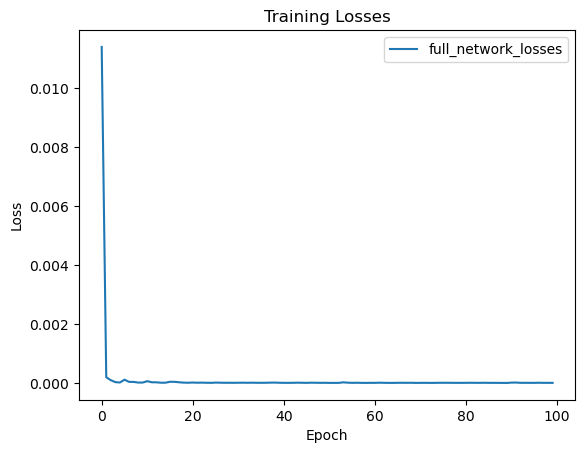

In [10]:
# Init GLFW, creat window, make OpenGL context current, request v-sync
glfw.init()
window = glfw.create_window(1200, 900, "Demo", None, None)
glfw.make_context_current(window)
glfw.swap_interval(1)

# initialize visualization data structures
mj.mjv_defaultCamera(cam)
mj.mjv_defaultOption(opt)
scene = mj.MjvScene(model, maxgeom=10000)
context = mj.MjrContext(model, mj.mjtFontScale.mjFONTSCALE_150.value)

# install GLFW mouse and keyboard callbacks
glfw.set_key_callback(window, keyboard)
glfw.set_cursor_pos_callback(window, mouse_move)
glfw.set_mouse_button_callback(window, mouse_button)
glfw.set_scroll_callback(window, scroll)

# Example on how to set camera configuration
# initialize the controller here. This function is called once, in the beginning
cam.azimuth = 89.83044433593757 ; cam.elevation = -20 ; cam.distance = 15.04038754800176
cam.lookat = np.array([0.0, 0.0, 0.0])

# intialize the controller
# init_controller(model, data)

# set the controller
mj.set_mjcb_control(controller)

N = 100
mj.mj_forward(model,data)

# print(position_Q)

i = 0
time = 0
dt =0.0025

max_loss = 0.01
muscle_losses = []  # List to store muscle autoencoder losses
sensor_losses = []  # List to store sensor autoencoder losses
kalman_losses = []
full_network_losses=[]


for epoch in tqdm(range(N), desc="Simulation Progress"):
    time_prev = data.time
    # time_prev = time

    # Training loop
    muscle_running_loss = 0.0
    sensor_running_loss = 0.0
    kalman_running_loss = 0.0
    latent_state_running_loss = 0.0
    epoch = 0

    while (data.time - time_prev < 1.0/60.0):
    # while (time - time_prev < 1.0/60.0):

        # num_actuators = model.na
        latent_muscle_activation = np.zeros([int(num_actuators/4)])
        latent_muscle_activation[int(i%(num_actuators/4))] = 0.9
        latent_muscle_activation = torch.tensor(latent_muscle_activation, dtype=torch.float32)

        full_network_optimizer.zero_grad()
        latent_state_est = full_network(latent_muscle_activation)

        muscle_optimizer.zero_grad()
        sensor_optimizer.zero_grad()
        muscle_activation_est = muscle_decoder(latent_muscle_activation)
        data.ctrl[:] = muscle_activation_est.detach().numpy()
        mj.mj_step(model, data)
        muscle_length = data.actuator_length
        muscle_length = torch.tensor(muscle_length, dtype=torch.float32)
        latent_state = sensor_encoder(muscle_length)

        latent_state_loss = criterion(latent_state_est, latent_state)
        latent_state_loss.backward()
        full_network_optimizer.step()

        if i%5 == 0:
            muscle_decoder.load_state_dict(full_network.part1.state_dict())
            sensor_encoder.load_state_dict(full_network.part3.state_dict())


        latent_state_running_loss += latent_state_loss.item()

    i += 1

    # Calculate average losses
    # avg_muscle_loss = muscle_running_loss / i
    # avg_sensor_loss = sensor_running_loss / i
    # avg_kalman_loss = kalman_running_loss / i

    # muscle_losses.append(avg_muscle_loss)  # Append muscle loss to the list
    # sensor_losses.append(avg_sensor_loss)  # Append sensor loss to the list
    # kalman_losses.append(avg_kalman_loss)
    full_network_losses.append(latent_state_running_loss)

    # print(f"Epoch {epoch + 1}, Muscle Loss: {avg_muscle_loss}, Sensor Loss: {avg_sensor_loss}")

    # Check if the average loss is below the desired threshold
    # if avg_muscle_loss < max_loss and avg_sensor_loss < max_loss and avg_kalman_loss < max_loss:
        # print("Training stopped: Loss reached the desired threshold.")
        # break


    # if (data.time>=simend):
    #     plt.figure(1)
    #     plt.subplot(2,1,1)
    #     # plt.plot(t,qact0,'r-')
    #     # plt.plot(t,qref0,'k');
    #     plt.plot(t,np.subtract(qref0,qact0),'k')
    #     plt.ylabel("error position joint 0")
    #     plt.subplot(2,1,2)
    #     # plt.plot(t,qact1,'r-')
    #     # plt.plot(t,qref1,'k');
    #     plt.plot(t,np.subtract(qref1,qact1),'k')
    #     plt.ylabel("error position joint 0")
    #     plt.show(block=False)
    #     plt.pause(10)
    #     plt.close()
    #     break;

    # get framebuffer viewport
    viewport_width, viewport_height = glfw.get_framebuffer_size(window)
    viewport = mj.MjrRect(0,0,viewport_width, viewport_height)

    # print camera configuration (help to initialize the view)
    if (print_camera_config==1):
        print('cam.azimuth =', cam.azimuth,';','cam.elevation =',cam.elevation,';','cam.distance =',cam.distance)
        print('cam.lookat = np.array([',cam.lookat[0],',',cam.lookat[1],',',cam.lookat[2],'])')

    # Update scene and render
    mj.mjv_updateScene(model, data, opt, None, cam,
                       mj.mjtCatBit.mjCAT_ALL.value, scene)
    mj.mjr_render(viewport, scene, context)

    # swap OpenGL buffers (blocking call due to v-sync)
    glfw.swap_buffers(window)

    # process pending GUI events, call GLFW callbacks
    glfw.poll_events()

# Plot the losses after training
# print("muscle_losses", muscle_losses)
# print("\nsensor_losses", sensor_losses)
# print("\nkalman_losses", kalman_losses)
print("\nfull_network_losses", full_network_losses)

# plt.plot(muscle_losses, label='Muscle Autoencoder Loss')
# plt.plot(sensor_losses, label='Sensor Autoencoder Loss')
# plt.plot(kalman_losses, label='Kalman Estimator Loss')
plt.plot(full_network_losses, label='full_network_losses')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Losses')
plt.legend()
plt.show()

glfw.terminate()
